## Parameters and Imports

In [6]:
runs_folder = 'Macro_TESA_Res4'
lr = 1e-5
solvent_vectorizer = 'solvent_macro_props1'
solute_vectorizer = 'solute_TESA'
norm_bools = (True, True, True)
Res_Dict = {'base_filters':2, 'kernel_size':3, 'stride':2, 'groups':1, 'n_block':3, 'n_classes':1, 'use_bn':True, 'use_do':True, 'verbose':False}
epochs = 10000

comments = f"""solute: {solvent_vectorizer}
                solute: {solute_vectorizer}
                norm: {norm_bools}
                learning rate: {lr}
                Res_Dict: {Res_Dict}
                epochs: {epochs}
            """

In [7]:
from config import project_path

In [8]:
project_path('Tables')

'/Users/balepka/PycharmProjects/msuAI/Tables'

In [9]:
from torch.utils.data import DataLoader
from my_nets.Create_dataset import *
from Vectorizers.vectorizers import *
from my_nets.LinearNet import *
from my_nets.ResNET import  *
from my_nets.net_func import *
import pickle

In [10]:
for folder in ('Runs/', 'Run_results/'):
    try:
        os.makedirs(project_path(folder+runs_folder))
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

    with open(project_path(folder+runs_folder+'/comments.txt'), 'w') as f:
        f.write(comments)

## Create dataset

In [11]:
table_v1 = pd.read_table(project_path('Tables/SS_table_v3.tsv'))
dataset = SS_Dataset(table_v1, solvent_vectorizer, solute_vectorizer, normalize=norm_bools)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len_data - val_data, val_data])

solvent_table = pd.read_table(project_path('Tables/solvent_test_table_v3.tsv'))
solute_table = pd.read_table(project_path('Tables/solute_test_table_v3.tsv'))
solvent_test_dataset = SS_Dataset(solvent_table, solvent_vectorizer, solute_vectorizer,
                                  normalize=norm_bools, show_norm_params=False)
solute_test_dataset = SS_Dataset(solute_table, solvent_vectorizer, solute_vectorizer,
                                 normalize=norm_bools, show_norm_params=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

solvent_test_loader = DataLoader(solvent_test_dataset, batch_size=46, shuffle=False)
solute_test_loader = DataLoader(solute_test_dataset, batch_size=64, shuffle=False)

print(f'train length: {len(train_loader.dataset)}')
print(f'val length: {len(val_loader.dataset)}')
print(f'solute test length: {len(solute_test_loader.dataset)}')
print(f'solvent test length: {len(solvent_test_loader.dataset)}')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/balepka/PycharmProjects/msuAI/Solvation_1/Tables/Entire_table3.tsv'

## Training Network

In [5]:
x, y = next(iter(dataset))


In [6]:
x.shape

torch.Size([1, 16])

In [7]:
in_feat = next(iter(dataset))[0].shape[0]
verbose = False

model = ResNet1D(in_feat, **Res_Dict)
loss_function = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

MSE = train(model,train_loader, val_loader, solvent_test_loader, solute_test_loader, loss_function, optimizer, epochs=epochs, ckp_path=runs_folder)

epoch 0: val loss (1e+16 -> 0.8780884146690369). Saving model
epoch 5: val loss (0.8780884146690369 -> 0.8682008981704712). Saving model
epoch 10: val loss (0.8682008981704712 -> 0.8731076717376709)
epoch 15: val loss (0.8682008981704712 -> 0.8626474142074585). Saving model
epoch 20: val loss (0.8626474142074585 -> 0.864872932434082)
epoch 25: val loss (0.8626474142074585 -> 0.8646112084388733)


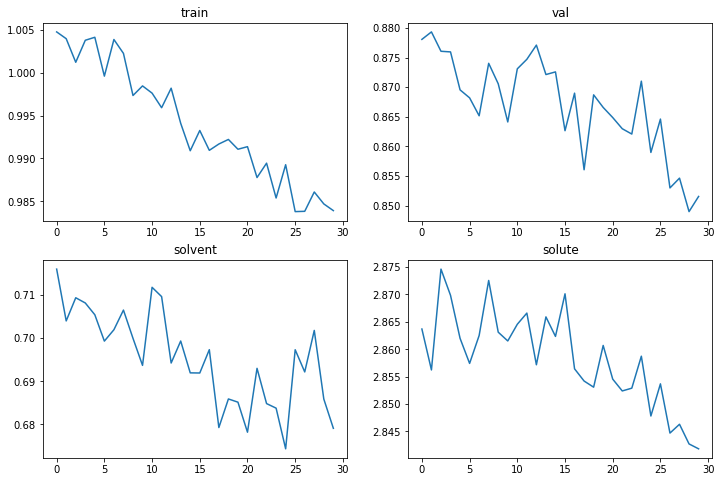

In [8]:
plot_losses(project_path('Run_results/'+runs_folder+'/run_log.tsv'))